# EM Algorithm for Gaussian Mixtures

In [13]:
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement

## Dataset

In [12]:
data_df = pd.read_csv('dataset/CSE575-HW03-Data.csv', header=None)
print('data shape: ', data_df.shape)
print('data type: ', data_df.dtypes)
data_df.head()

data shape:  (128, 13)
data type:  0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


## Clean the Data (Missing Value)

In [4]:
data_df = data_df.fillna(data_df.mean())
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


In [5]:
data_x = data_df.to_numpy()
print('dataset in numpy array with shape: ', data_x.shape)

dataset in numpy array with shape:  (128, 13)


## Define the Multivariate Normal Distribution

In [204]:
def p_normal_dist(x, mean, covariance):
    """
    x is a d-dimensional vector in the shape of (d, )
    mean is the mean of the normal distribution
    covariance is the the covariance matrix
    """
    d = x.shape[0]
    x_m = x - mean
    xm = np.reshape(x_m, (d, 1))
    if np.linalg.det(covariance) < 0:
        print('Warning: negative determinant')
    part_0 = 1.0 / np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))
    part_1 = np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2)
    return part_0*part_1

### Verify the Correctness by Visualizing the Distribution

- Citation: https://peterroelants.github.io/posts/multivariate-normal-primer/

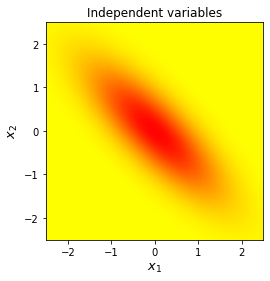

In [213]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = p_normal_dist(np.array([x1[i,j], x2[i,j]]), mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)


def plot_bivariate_distribution():
    ax1 = plt.gca()
    d = 2  # number of dimensions

    # Plot of independent Normals
    bivariate_mean = np.array([0., 0.])  # Mean
    bivariate_covariance = np.array([[1, -0.8], [-0.8, 1]])  # Covariance
    x1, x2, p = generate_surface(bivariate_mean, bivariate_covariance, d)
    # Plot bivariate distribution
    con = ax1.contourf(x1, x2, p, 100, cmap='autumn_r')
    ax1.set_xlabel('$x_1$', fontsize=13)
    ax1.set_ylabel('$x_2$', fontsize=13)
    ax1.axis([-2.5, 2.5, -2.5, 2.5])
    ax1.set_aspect('equal')
    ax1.set_title('Independent variables', fontsize=12)

plot_bivariate_distribution()

## Implement EM Algorithm for Gaussian Mixtures

### Define helper functions

In [219]:
def get_responsibility(x, component_k, k, mu, sigma, pi):
    sum_denominator = 0
    sum_numerator = 0
    for i in range(0, k):
        respond_component_i = pi[i]*p_normal_dist(x, mu[i], sigma[i])
        if i == component_k:
            sum_numerator = respond_component_i
        sum_denominator += respond_component_i

    return sum_numerator/float(sum_denominator)


def get_mixture_prob(x, mu, sigma, pi):
    prob_sum = 0
    k = pi.shape[0]
    for i in range(0, k):
        prob_sum += pi[i]*p_normal_dist(x, mu[i], sigma[i])
    return prob_sum


def get_label(x, mu, sigma, pi):
    k = mu.shape[0]
    
    label = None
    prob = None
    for i in range(0, k):
        prob_i = pi[i]*p_normal_dist(x, mu[i], sigma[i])
        if prob is None or prob_i > prob:
            label = i
            prob = prob_i
    return label
    

### The k-means function

In [299]:
def do_EM_gaussian_mixtures(X, k, mu=None, sigma=None, pi=None):
    """
    X is the dataset
    k is the number of Gaussians
    mu is the mean of each Gaussian
    sigma is the covariance matrix of each Gaussian
    pi is the list of p(z_k=1)
    """
    n_x = X.shape[0]
    dimension = X.shape[1]
    # init means
    if mu is None:
        x_idx = sample_without_replacement(n_population=n_x, n_samples=k)
        mu = X[x_idx]
    # init covariance matrix
    if sigma is None:
        sigma = np.ones(shape=(k, dimension, dimension), dtype=np.float64)
        for i in range(0, k):
            sigma[i] = np.diag(np.diag(np.ones(shape=(dimension, dimension), dtype=np.float64)))
    # init pi
    if pi is None:
        pi = np.ones(shape=(k, ), dtype=np.float64)/float(k)
    
    is_converged = False
    iteration = 0
    r = np.zeros(shape=(n_x, k), dtype=np.float64)
    while not is_converged:
        is_converged = True
        old_mu = np.copy(mu)
        old_sigma = np.copy(sigma)
        old_pi = np.copy(pi)
        
        # E-step: calculate r
        for x_i, x in enumerate(X):
            for j in range(0, k):
                r[x_i][j] = get_responsibility(x, j, k, mu, sigma, pi)
        
        # M-step
        for j in range(0, k):
            sum_for_mu = 0
            sum_for_sigma = np.zeros(shape=(dimension, dimension), dtype=np.float64)
            n_k = 0
            for x_i, x in enumerate(X):
                sum_for_mu += r[x_i][j]*x
                x_m = np.reshape(x - mu[j], (dimension, 1))
                sum_for_sigma += r[x_i][j]*np.dot(x_m, x_m.T)
                n_k += r[x_i][j]

            # update means mu
            mu[j] = sum_for_mu/n_k
            
            # update covariance matrix
            sigma[j] = sum_for_sigma/n_k
            
            # update pi
            pi[j] = n_k/n_x
        
        # test if the convergence condition is met
        if np.linalg.norm(mu - old_mu) > 0.000001:
            is_converged = False
        if np.linalg.norm(sigma - old_sigma) > 0.000001:
            is_converged = False
        if np.linalg.norm(pi - old_pi) > 0.000001:
            is_converged = False
            
        iteration += 1
        log_str = '\rk: %d, iteration %d' % (k, iteration)
        sys.stdout.write(log_str)
        sys.stdout.flush()
    
    print('\nk=%d: converged after %d iteration.' % (k, iteration))
    return mu, sigma, pi

    

In [304]:
def run_evaluation(X, k_list):
    mu_log = []
    sigma_log = []
    pi_log = []
    for k in k_list:
        info = do_EM_gaussian_mixtures(X, k)
        mu_log.append(info[0])
        sigma_log.append(info[1])
        pi_log.append(info[2])

    return mu_log, sigma_log, pi_log

k_list = [2]
mu_log, sigma_log, pi_log = run_evaluation(data_x, k_list)

k: 2, iteration 59
k=2: converged after 59 iteration.


## Visualize the Result

### For k = 2, plot the points using its first two features. Use two different colors or symbols to distinguish the two clusters

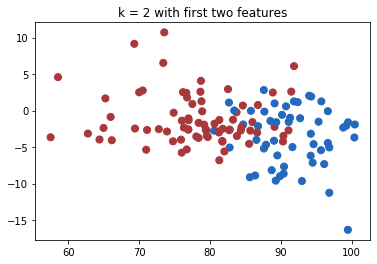

In [309]:
def plot_contour_gaussian(mu, sigma, color='r'):
    x = np.linspace(50, 110, 200)
    y = np.linspace(-20, 20, 200)

    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros(shape=(x.shape[0], y.shape[0]))
    for i in range(0, x.shape[0]):
        for j in range(0, y.shape[0]):
            Z[i, j] = p_normal_dist(np.array([x[i], y[j]]), mu, sigma)
            
    plt.contour(X, Y, Z, colors=color)
    

def plot_two_features(data, mu, sigma, pi, is_plot_gaussian_contour=False):
    # we first plot the contour of each gaussian components
    k = mu.shape[0]
    if is_plot_gaussian_contour:
        colors = ['r', 'b']
        for i in range(0, k):
            plot_contour_gaussian(mu[i, 0:2], sigma[i, 0:2, 0:2], color=colors[i % 2])
    
    r = np.zeros(shape=(data.shape[0], ))
    for i in range(0, data.shape[0]):
        r[i] = get_label(data[i], mu, sigma, pi)
    plt.scatter(data[:, 0], data[:, 1], c=r, s=50, cmap='vlag')
    plt.title('k = 2 with first two features')

plot_two_features(data_x, mu_log[0], sigma_log[0], pi_log[0])

## Compare to Gaussian model in sklearn

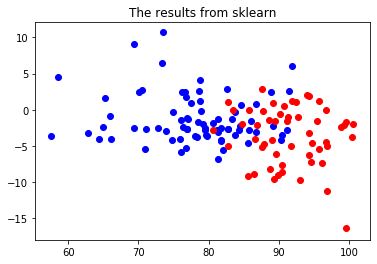

In [310]:
from sklearn.mixture import GaussianMixture 
def plot_gaussian_sklearn():
    gmm = GaussianMixture(n_components = 2)
    gmm.fit(data_df)
    labels = gmm.predict(data_df) 
    d = data_df.copy()
    d['labels']= labels 
    d0 = d[d['labels']== 0] 
    d1 = d[d['labels']== 1] 

    plt.scatter(d0[0], d0[1], c ='b') 
    plt.scatter(d1[0], d1[1], c ='r')
    plt.title('The results from sklearn')
    
plot_gaussian_sklearn()